In [162]:
!python -V

Python 3.10.8


In [163]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy as sp
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

import pickle
import pgzip
import os, psutil

from joblib import Parallel, delayed
N_JOBS=7
from tqdm.notebook import tqdm
# from tqdm import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 
warnings.formatwarning = lambda s, *args: "Warning: " + str(s)+'\n'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [164]:
use_cache = False
output_prefix = "output/entangled_halo_proj/("+\
                datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + \
                str("T" if use_cache else "F") + \
                ") "
output_ext = ".pgz.pkl"
print(output_prefix)

output/entangled_halo_proj/(20230206-071547-F) 


In [165]:
import platform
if not use_cache:
    with open(output_prefix + "session_info.txt", "wt") as file:
        string = ""
        string += ("="*20 + "Session System Information" + "="*20) + "\n"
        uname = platform.uname()
        string +=  f"Python Version: {platform.python_version()}\n"
        string +=  f"Platform: {platform.platform()}\n"
        string += (f"System: {uname.system}")+ "\n"
        string += (f"Node Name: {uname.node}")+ "\n"
        string += (f"Release: {uname.release}")+ "\n"
        string += (f"Version: {uname.version}")+ "\n"
        string += (f"Machine: {uname.machine}")+ "\n"
        string += (f"Processor: {uname.processor}")+ "\n"
        string +=  f"CPU Counts: {os.cpu_count()} \n"
    #     print(string)
        file.write(string)

## Simulation Parameters

In [175]:
nx = 120+1
nz = 80+1
xmax = 70 # Micrometers
# xmax = 20 * 0.001 # Millimeters
zmax = (nz/nx)*xmax
dt = 4e-3 # Milliseconds
# dt = 1e-5 # Seconds
# dt = 0.1 # Microseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
# hb = 0.0635077993 # ("AtomicMassUnit" ("Micrometers")^2)/("Microseconds")
# hb = 0.0000635077993 #  ("AtomicMassUnit" ("Millimeters")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pxmax)
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
print("(dpx,dpz) = ", (dpx, dpz))

print(round((nx*nz)**2/1000/1000,3),"million grid points (ideally want around 1M magnitude)")
print(round((nx*nz)**2*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

assert ((nx*nz)**2 < 1000**4), "This is in the terra range! too big!"

zmax = 46.85950413223141
(dx,dz) = (1.1666666666666667, 1.1714876033057853)
rotate phase = 0.023233390173847315j
pxmax = 173.86362733520917
pzmax = 173.86362733520917
(dpx,dpz) =  (2.8502233989378554, 4.2577411268084004)
96.06 million grid points (ideally want around 1M magnitude)
1.6 minutes/grid_op (for 1μs/element_op)


In [176]:
wavelength = 1.083 #Micrometers
k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
k = 0.03 * 2*pi / wavelength
dopd = 60.1025 # 1/ms Doppler detuning (?)
p = 2*hb*k
print("k  =",k,"1/µm")
print("p  =",p, "u*µm/ms")
v4 = hb*k/m4
print("v4 =",v4, "µm/ms")
print("sigma_x =", hb/10, " handwavy heisenberg momentum uncertainty ")
print(2*pi / (2*k), "x-period of cosin bragg lattice")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"
assert (dpx < hb/2 and dpz < hb/2), "momentum resolution step too big"
assert (2*pi / (2*k) > 10*dx), "not even ten x-steps in cosin wave!"

k  = 0.1740494544925093 1/µm
p  = 22.106995892038764 u*µm/ms
v4 = 2.7633744865048455 µm/ms
sigma_x = 6.35078  handwavy heisenberg momentum uncertainty 
18.05 x-period of cosin bragg lattice


In [177]:
a4 = 0.007512 # scattering length 
omega = 10 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
print("tBraggPi     =", round(tBraggPi,3),"µs")
print("tBraggCenter =", round(tBraggCenter,3),"µs")
print("tBraggEnd    =", round(tBraggEnd,3),"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

def VB(t, tauMid, tauPi):
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000
def VBF(t, tauMid, tauPi, V0FArg=V0F):
        return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)
    
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

V0 = 1270.156
tBraggPi     = 0.016 µs
tBraggCenter = 0.079 µs
tBraggEnd    = 0.157 µs
6.298438931910726e-05j term infront of Bragg potential
2.029334545749751j max(V)


In [178]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz, nx,nz),dtype=np.clongdouble)
psi=np.random.rand(nx,nz, nx,nz) + 1j*np.random.rand(nx,nz, nx,nz)
print(round(psi.nbytes/1000/1000 ,3) , "MB per psi 2d*2d array")

xgrid = np.tensordot(xlin, np.ones(nz), axes=0)
cosXGrid = np.cos(2*k*xgrid)
x3grid = np.tensordot(xgrid, np.ones((nx,nz)), axes=0)
x4grid = np.tensordot(np.ones((nx,nz)), xgrid, axes=0)
cosX3Grid = np.cos(2*k*x3grid)
cosX4Grid = np.cos(2*k*x4grid)

process = psutil.Process(os.getpid())
def current_py_memory(): return process.memory_info().rss;
def current_py_memory_print(): print(str(round(current_py_memory()/1000**2,3)) + "MB of system memory used")
momory_bytes = current_py_memory()
if (momory_bytes/1000**3 > 1): 
    warnings.warn(str(round(momory_bytes/1000**3,3))+" GB of system memory used already! careful!")
else:
    print(momory_bytes/1000**2 , "MB of system memory used")

1536.954 MB per psi 2d*2d array


In [179]:
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 

### Checking parameters

1270.154961328156


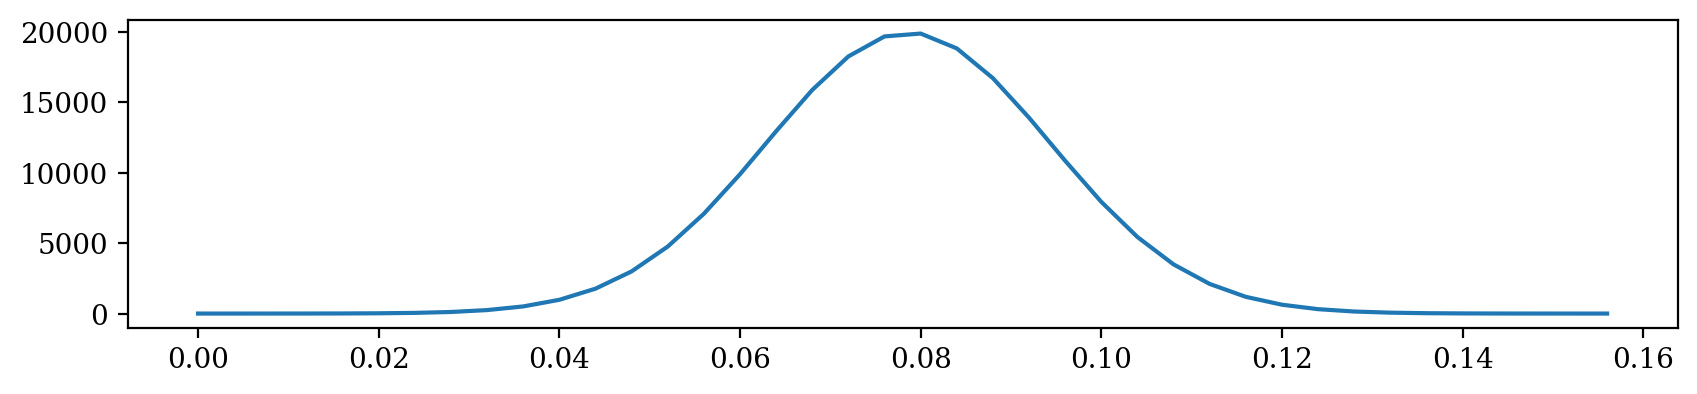

In [180]:
# smooth bragg in time
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
# plt.plot(tbtest, V(tbtest))

plt.figure(figsize=(10,2))
plt.plot(tbtest, VBF(tbtest,tBraggPi*5,tBraggPi))
print(np.trapz(V(tbtest),tbtest)) # this should be V0

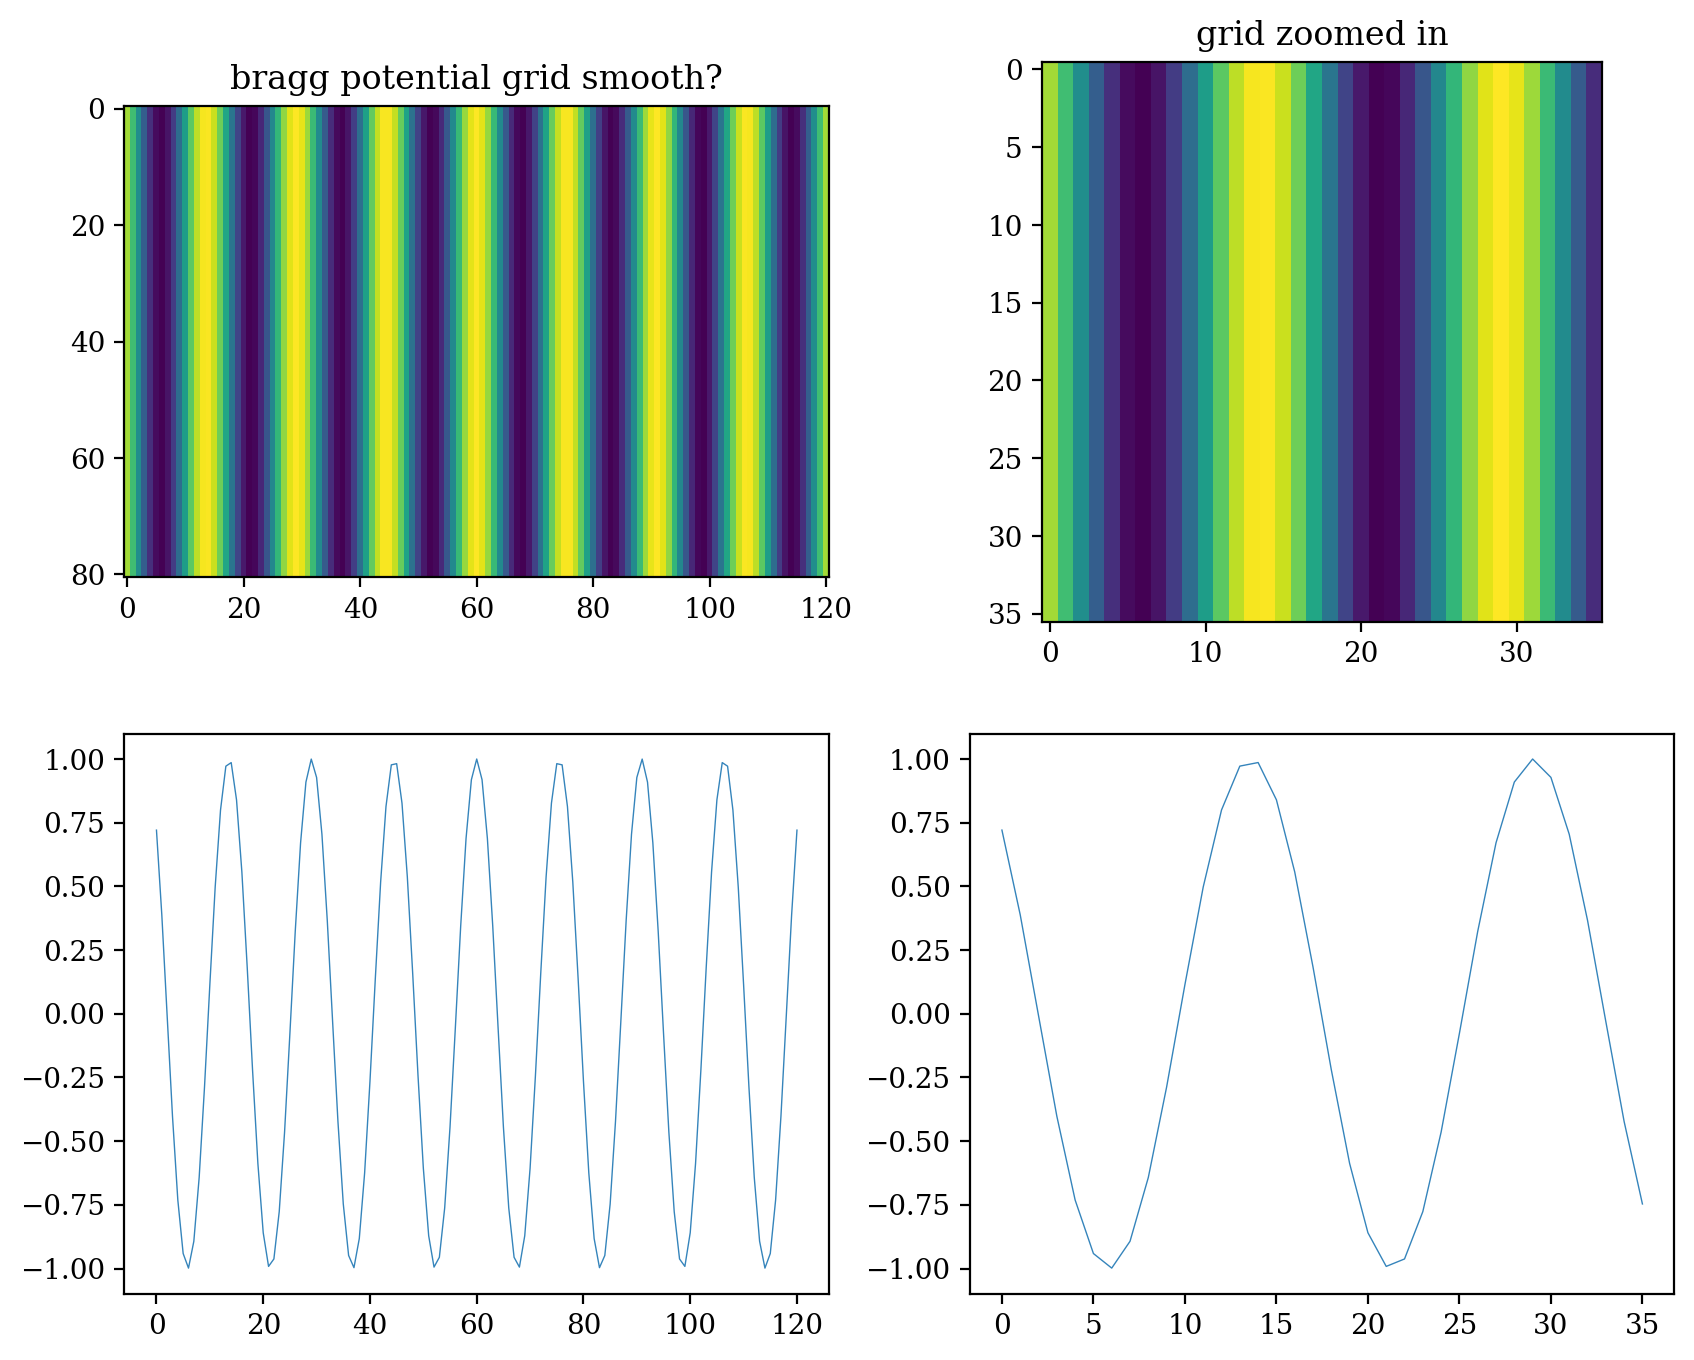

In [181]:
# vtest = np.cos(2*k*xlin)
ncrop = int(0.3*nx)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(cosXGrid.T)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosXGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosXGrid[:,0],alpha=0.9,linewidth=0.5)

plt.subplot(2,2,4)
plt.plot(cosXGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()
del ncrop

In [127]:
cosXTest = (nx)**-1 * np.trapz(np.trapz(cosX3Grid,dx=dz,axis=3),dx=dx,axis=2)

## initial wave function

In [201]:
sg = 8;
def psi0gaussianNN(x3, z3, x4, z4, sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0):
    return    np.exp(-0.5*x3**2/sx3**2)\
            * np.exp(-0.5*z3**2/sz3**2)\
            * np.exp(-0.5*x4**2/sx4**2)\
            * np.exp(-0.5*z4**2/sz4**2)\
            * np.exp(+(1j/hb)*(px3*x3 + pz3*z3 + px4*x4 + pz4*z4))

def check_norm(psi):
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)

def psi0gaussian(sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0):
    psi=np.zeros((nx,nz, nx,nz),dtype=np.clongdouble)
    for (iz3, z3) in enumerate(zlin):
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
    normalisation = check_norm(psi)
    return psi/sqrt(normalisation)

def only3(psi):
    return np.trapz(np.trapz(psi,dx=dz,axis=3),dx=dx,axis=2)
def only4(psi):
    return np.trapz(np.trapz(psi,dx=dx,axis=0),dx=dz,axis=0)



In [202]:
np.finfo(np.clongdouble)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [203]:
np.finfo(np.cdouble)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [204]:
np.finfo(np.csingle)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

#### Testings

check normalisation 0.9999999999999998


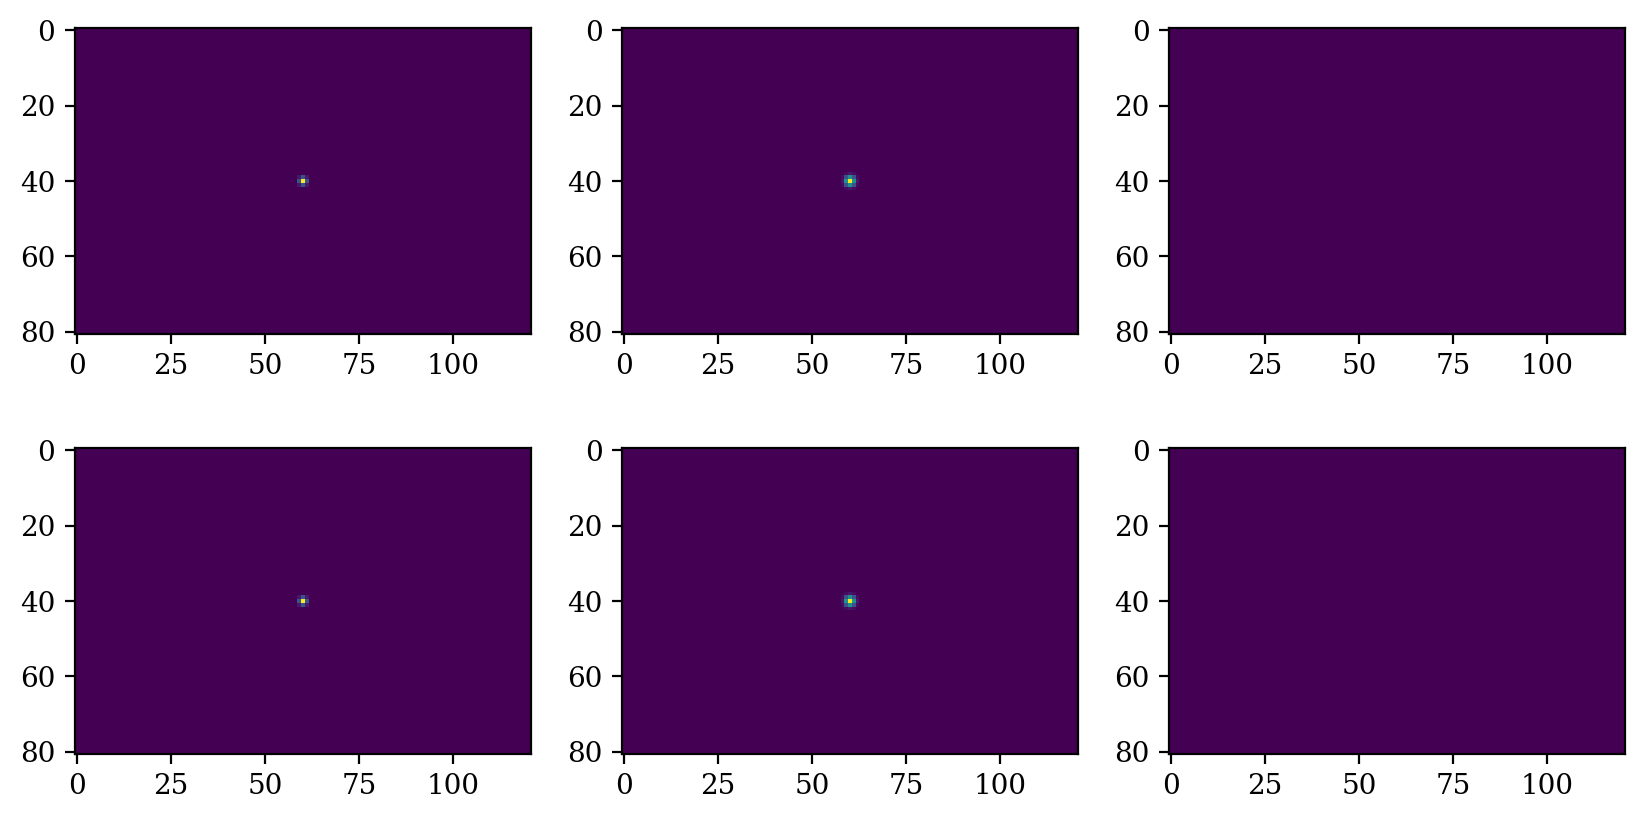

11325.669MB of system memory used


In [247]:
su = 1
psi = psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=0, pz3=0, px4=0, pz4=0)
print("check normalisation", check_norm(psi))

tempTest3 = only3(psi)
tempTest4 = only4(psi)
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(np.abs(tempTest3.T)**2)
plt.subplot(2,3,2)
plt.imshow(np.real(tempTest3.T))
plt.subplot(2,3,3)
plt.imshow(np.imag(tempTest3.T))

plt.subplot(2,3,4)
plt.imshow(np.abs(tempTest4.T)**2)
plt.subplot(2,3,5)
plt.imshow(np.real(tempTest4.T))
plt.subplot(2,3,6)
plt.imshow(np.imag(tempTest4.T))
plt.show()

current_py_memory_print()

In [248]:
psi.dtype

dtype('complex128')

## FFT to momentum

In [249]:
def only3phi(phi):
    return np.trapz(np.trapz(phi,dx=dpz,axis=3),dx=dpx,axis=2)
def only4phi(phi):
    return np.trapz(np.trapz(phi,dx=dpx,axis=0),dx=dpz,axis=0)
def check_norm_phi(phi):
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2),dx=dpz,axis=1),dx=dpx,axis=0)


In [250]:
# phiUN = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')))
phiUN = np.fliplr(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')))
# superWeirdNormalisationFactorSq = np.sum(np.abs(phiUN)**2)*dpx*dpz*dpx*dpz
superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
swnf = sqrt(superWeirdNormalisationFactorSq)
phi = phiUN/swnf

In [251]:
check_norm_phi(phi)

1.0

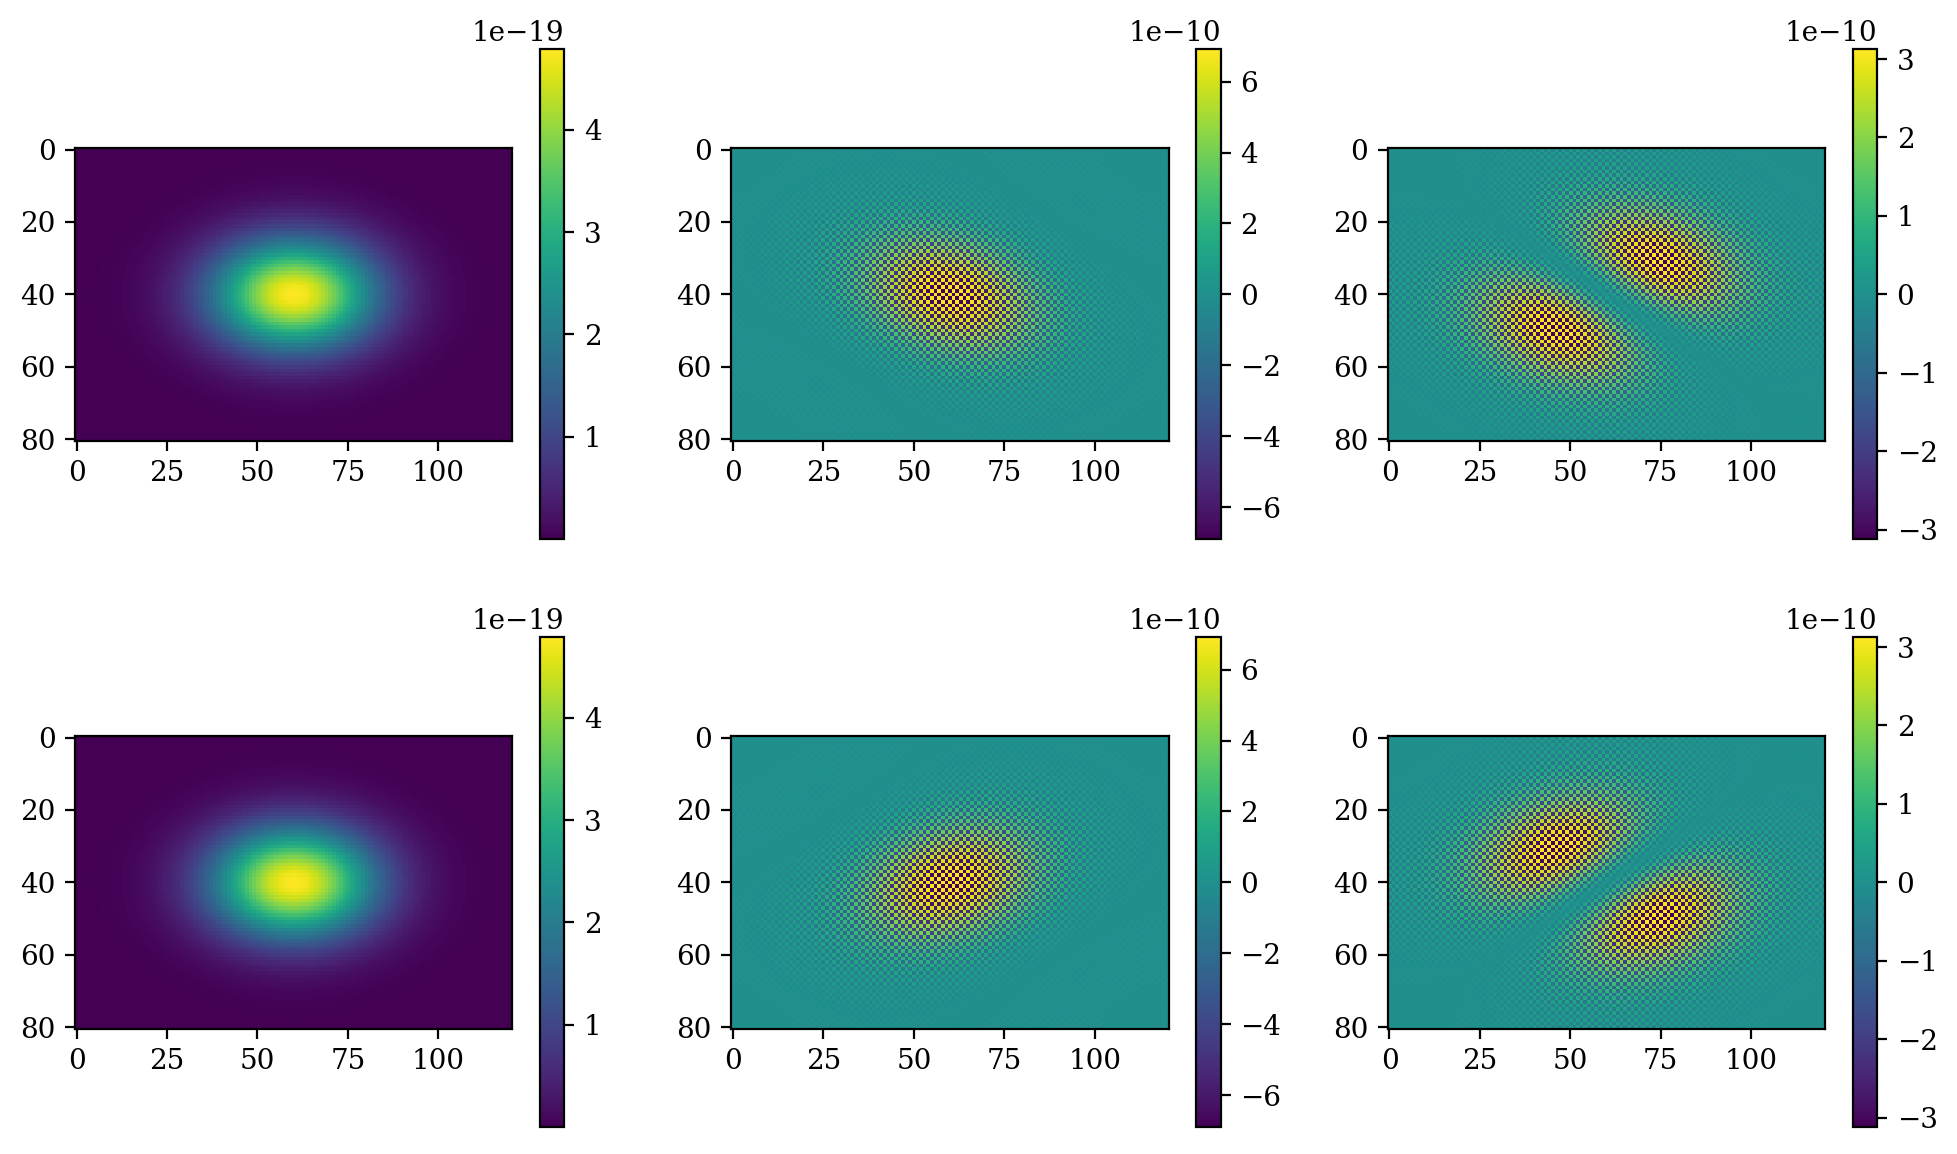

11329.88MB of system memory used


In [252]:
tempTest3 = only3phi(phi)
tempTest4 = only4phi(phi)
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.imshow(np.abs(tempTest3.T)**2)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.real(tempTest3.T))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(np.imag(tempTest3.T))
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow(np.abs(tempTest4.T)**2)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.real(tempTest4.T))
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(np.imag(tempTest4.T))
plt.colorbar()

plt.show()

current_py_memory_print()

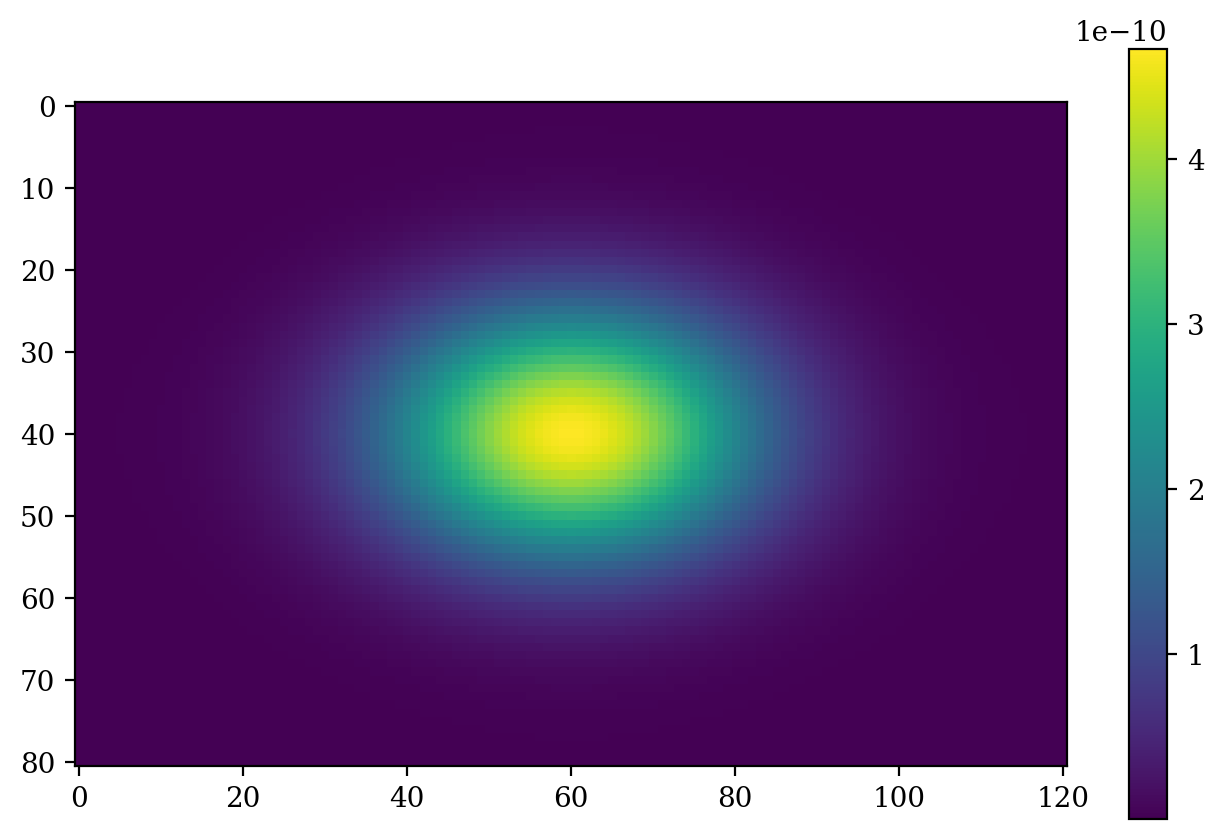

In [253]:
plt.imshow(np.abs(phi[:,:,40,20].T)**2)
plt.colorbar()

In [254]:
temptemp = np.trapz(phi, pzlin, axis=3)

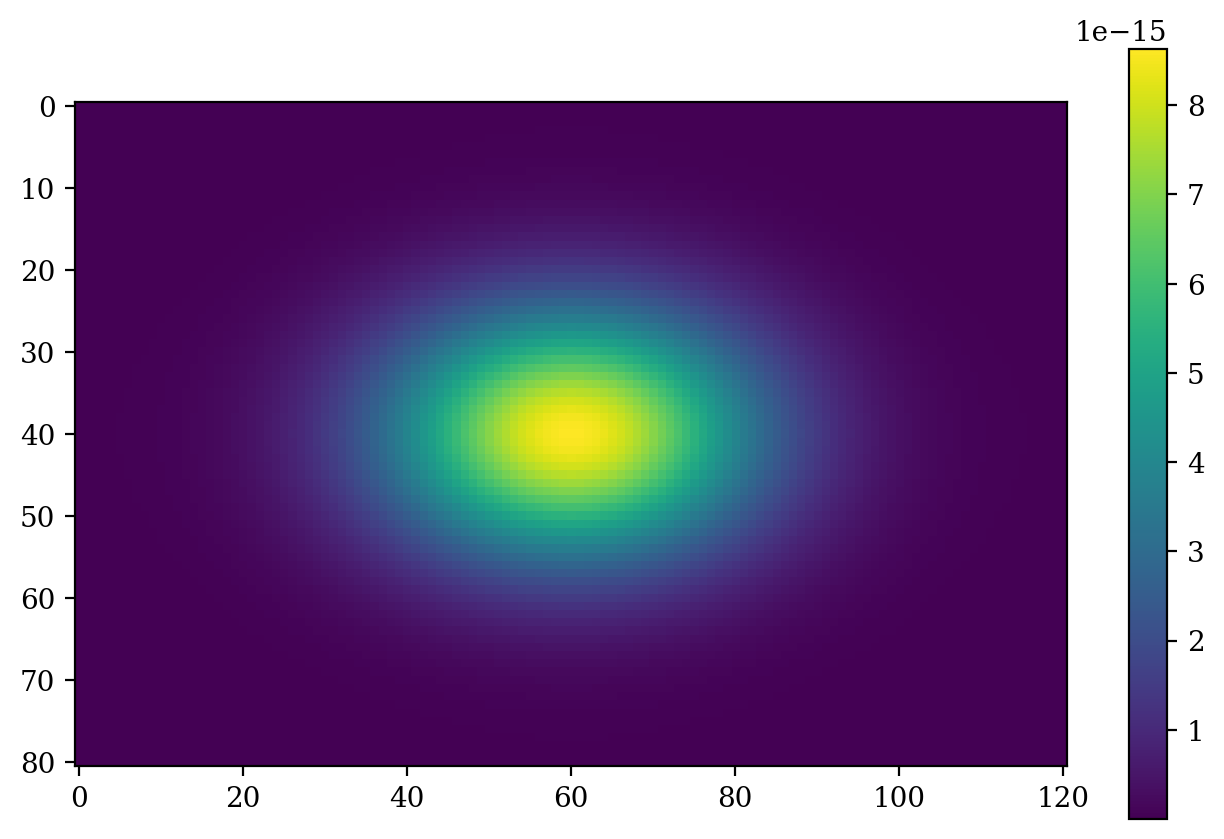

In [255]:
plt.imshow(np.abs(temptemp[:,:,23].T)**2)
plt.colorbar()

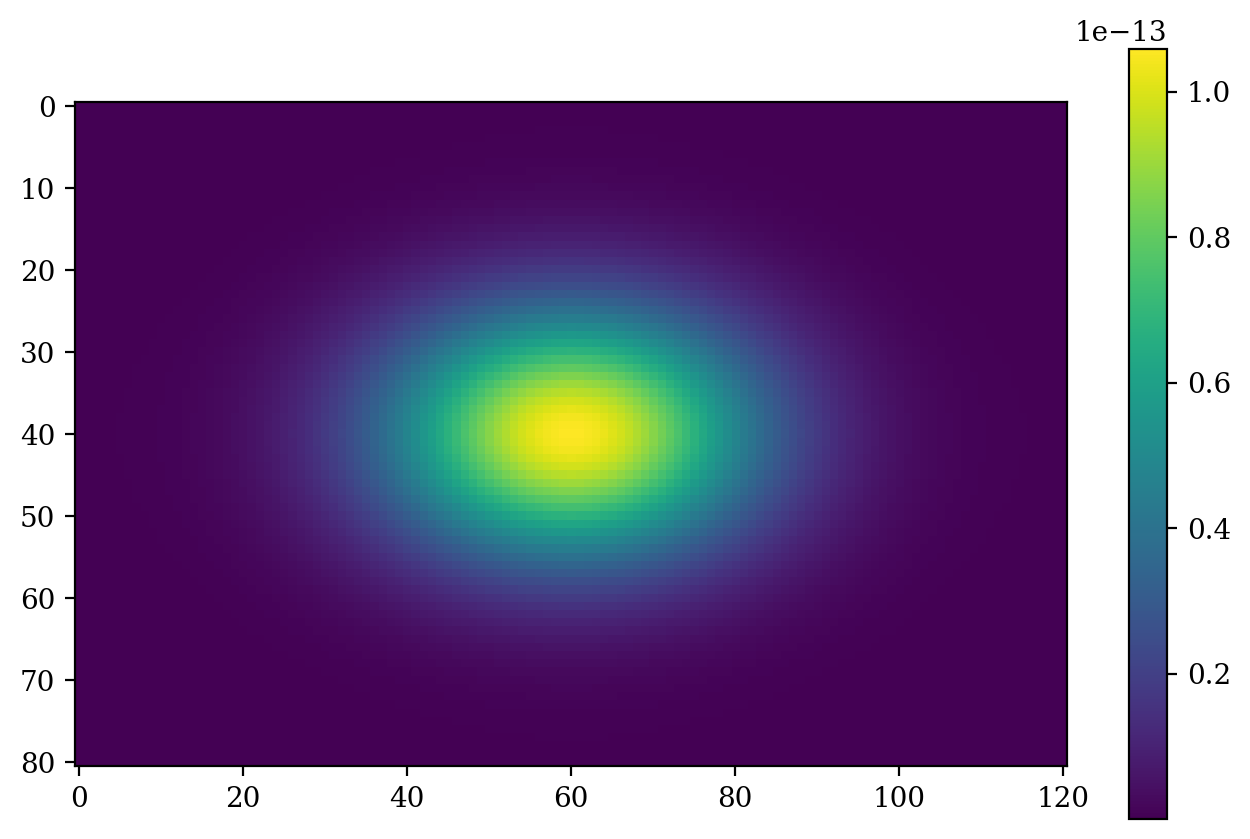

In [256]:
plt.imshow(np.abs(temptemp[:,:,50].T)**2)
plt.colorbar()

In [257]:
phi.dtype

dtype('complex128')

In [258]:
psi.dtype

dtype('complex128')

In [259]:
temptemp2 = np.trapz(temptemp, pxlin, axis=2)

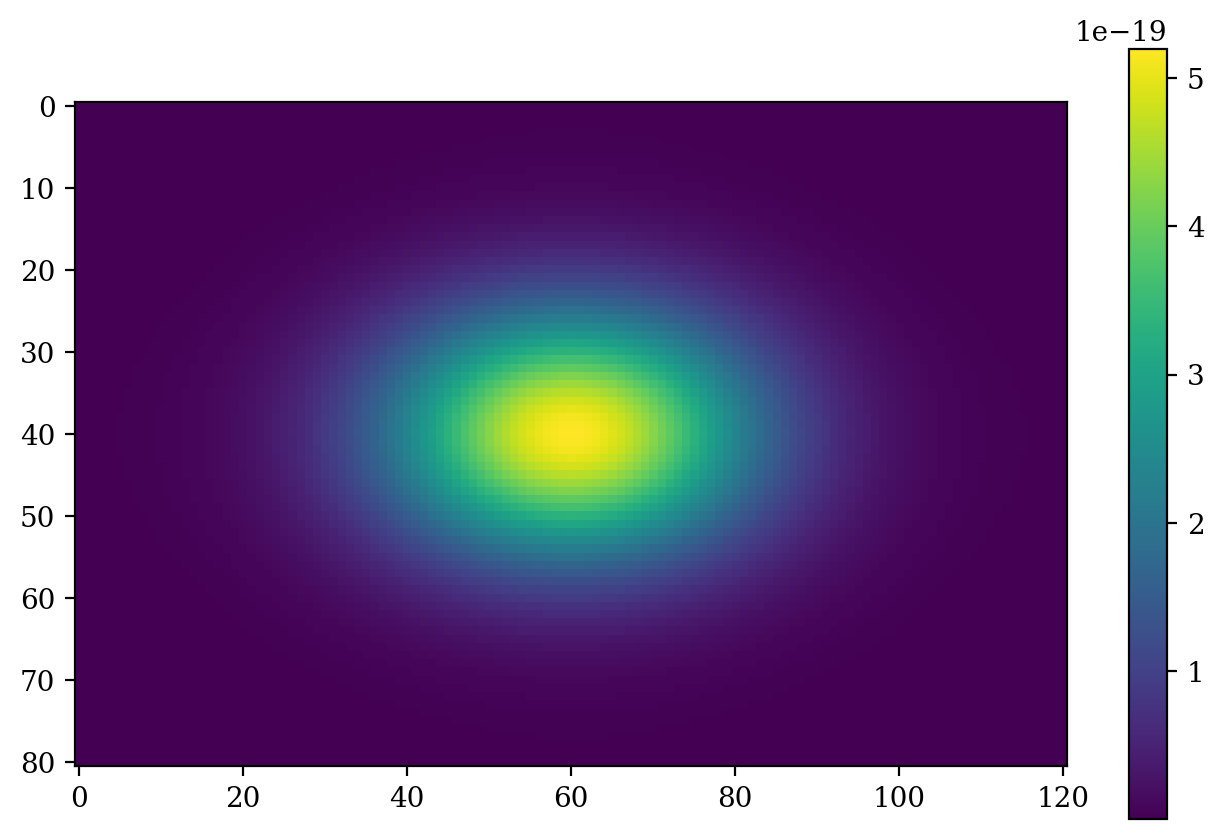

In [260]:
plt.imshow(np.abs(temptemp2.T)**2)
plt.colorbar()

In [261]:
temptemp3 = np.trapz(temptemp2, pzlin, axis=1)

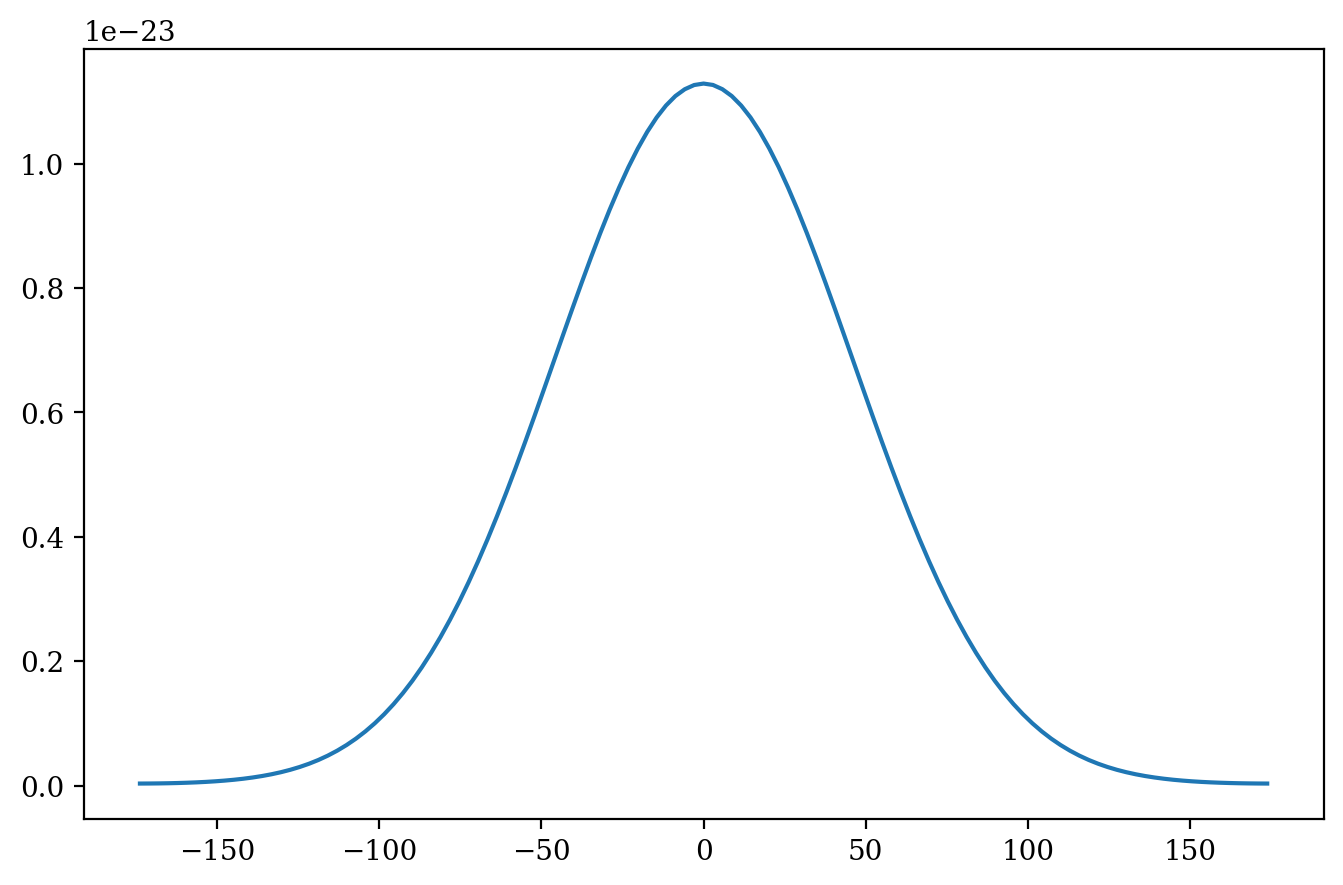

In [263]:
plt.plot(pxlin, np.abs(temptemp3)**2)

In [265]:
np.trapz(np.abs(temptemp3)**2, pxlin)

1.3041423812917345e-21